# Imports and helper functions

In [27]:
%matplotlib widget
# imports
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from Individual import Individual, FTYPE
from Population import Population
from RNASeqDeconvolution import RNASeqDeconvolution
from main import set_parameters, compare_to_true_results, DEFAULT_PARAMS, evaluate_deconvolution_solution


In [2]:
# helper function(s)
def as_dataframe(var, mat=None):
    """Return the given mat as a dataframe with labels matching those of var"""
    path_param = ("true_result_path" if var == 'X' else
                           "H_path" if var == 'H' else 
                           "M_path" if var == 'M' else None)
    if path_param is None:
        raise ValueError("var accepts 'X', 'H' or 'M' only")

    df = pd.read_csv(DEFAULT_PARAMS[path_param], sep="\t", index_col=0, header=0)
    if var == 'X':
        df = df.transpose()
    if mat is None:
        if var == 'X':
            df = df / 100
        return df
        
    col_labels = df.columns.to_list()
    row_labels = df.index.to_list()
    if var == 'X':
        return pd.DataFrame(mat * 100, columns=col_labels, index=row_labels).transpose()
    return pd.DataFrame(mat, columns=col_labels, index=row_labels)

def plot_fitness_and_diversity_over_time(best_history, diversity_history):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    l = np.arange(len(best_history))
    line1 = ax[0].plot(l, best_history, label="best fitness")
    ax[0].set_title("best fitness score in population")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Fitness score")
    
    line2 = ax[1].plot(l, diversity_history, label="diversity")
    ax[1].set_title("population diversity")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("diversity")

    plt.show()

def dataframe_heatmap(df: pd.DataFrame, figsize: Tuple[float, float] = (8, 6),
    cmap: str = "viridis", annot: bool = True, fmt: str = ".2f",
    vmin: Optional[float] = None, vmax: Optional[float] = None,
    cbar_label: Optional[str] = None, xlabel: Optional[str] = None,
    ylabel: Optional[str] = None, title: Optional[str] = None,
    show: bool = True) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a DataFrame as a heatmap while keeping row/column labels.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with numeric values.
    figsize : tuple
        Figure size (width, height).
    cmap : str
        Matplotlib colormap name.
    annot : bool
        Whether to print the numeric value in each cell.
    fmt : str
        Format string for annotations (e.g. ".2f").
    vmin, vmax : float or None
        Min/max for colormap scaling.
    cbar_label : str or None
        Label for the colorbar.
    xlabel, ylabel, title : str or None
        Optional axis labels and title.
    show : bool
        Whether to call plt.show() before returning.

    Returns
    -------
    (fig, ax)
        The matplotlib Figure and Axes objects.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame")

    try:
        data = df.values.astype(float)
    except Exception as e:
        raise ValueError("DataFrame contains non-numeric values that cannot be converted to float.") from e

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(data, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)

    # Set ticks and labels
    nrows, ncols = data.shape
    ax.set_xticks(np.arange(ncols))
    ax.set_yticks(np.arange(nrows))
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.index)

    # Optionally rotate x labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Minor grid lines for clearer cell boundaries (optional)
    ax.set_xticks(np.arange(-0.5, ncols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, nrows, 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Annotations
    if annot:
        for i in range(nrows):
            for j in range(ncols):
                ax.text(
                    j, i,
                    format(data[i, j], fmt),
                    ha="center", va="center",
                    fontsize=8
                )

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    if cbar_label:
        cbar.set_label(cbar_label)

    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    plt.tight_layout()
    if show:
        plt.show()

    return fig, ax

# Initializing and running experiments

In [3]:
TRUE = DEFAULT_PARAMS["TRUE"] # groundT
base_parameters = {"mut_prob": 0.01,
                     "crossover_prob": 0.8,
                     "mut_standard_deviation": 2,
                     "pop_size": 800,
                     "satisfactory": 1e-5,
                     "stagnation_limit": 200,
                     "stagnation_diff": 1e-4,
                     "tournament_participants": 3,
                     "win_probability": 0.9,
                     "init_sigma": 2.5,
                     "carry_over": 2,
                     "max_iter": 10000,
                     "niche_num": 4,
                     "migration_interval": 200,
                     "migrator_num": 10,
                     "use_marker_genes": False,
                     "top_n_marker_genes": 110,
                     "min_mean_marker_genes": 1e-6}

# Results

## run 1

In [4]:
parameters1 = base_parameters.copy()
parameters1["rng_seed"] = 85432
experiment1 = set_parameters(base_parameters, True)
experiment1.run()

running RNA-seq deconvolution:   0%|                                                                          …

stop reason: iteration limit


### Predicted sample$\times$cell-type matrix

In [5]:
as_dataframe('X', experiment1.result)

,Monocytes.C,NK,T.CD8.Memory,T.CD4.Naive,T.CD8.Naive,B.Naive,T.CD4.Memory,MAIT,T.gd.Vd2,Neutrophils.LD,T.gd.non.Vd2,Basophils.LD,Monocytes.NC.I,B.Memory,mDCs,pDCs,Plasmablasts,Unclassified
CYFZ,15.047931,8.351324,29.087262,4.335271e+00,7.496635e-08,5.066128,13.889407,1.332682e-07,3.261719e+00,1.108079,3.271254e+00,0.465658,8.156663,3.512796,1.606382e-06,6.693151e-01,3.239147,5.380441e-01
FY2H,31.757208,6.445447,4.859447,6.813548e+00,3.956376e-08,6.679843,8.403737,4.864439e-01,3.041987e-07,1.256446,2.138406e+01,0.167278,6.713527,0.000008,2.071513e+00,1.274978e+00,1.686514,3.690291e-07
FLWA,21.592048,27.731418,5.974212,2.334303e+00,2.822435e-07,6.766171,11.666384,3.336580e+00,5.555270e+00,1.337348,1.534684e-05,1.029001,1.987792,2.845896,3.120965e+00,6.143494e-01,4.108247,1.364436e-07
453W,23.985251,7.827397,20.684296,5.985351e+00,2.450135e+00,4.271725,14.784879,5.442867e-01,3.199820e+00,2.111966,2.233417e+00,0.312793,3.374577,1.917249,1.808250e+00,1.263448e+00,1.155142,2.090019e+00
684C,19.808753,7.312917,12.368148,6.729376e+00,2.656397e+00,9.471445,13.504070,2.541409e+00,1.881339e+00,1.277692,4.831633e-01,0.840338,3.557902,2.040141,8.447437e-01,1.006986e+00,10.756536,2.918644e+00
CZJE,20.302402,13.967696,1.631301,6.124889e-03,2.020473e+00,7.476859,21.953546,5.062034e+00,4.126682e+00,1.641691,1.807317e-07,0.706929,4.224958,5.000824,7.383768e+00,1.035658e+00,3.459053,4.998058e-07
925L,25.614868,10.117917,16.532024,6.813571e+00,2.601251e-07,17.733898,9.808716,6.666548e-01,3.243745e+00,1.373209,6.279680e-01,1.447350,1.038787,0.180845,2.548565e-07,3.253445e-01,1.823022,2.652080e+00
9JD4,20.028440,4.221527,20.879916,1.200013e+01,2.514483e+00,5.831502,9.177541,1.497941e+00,2.912052e+00,0.629299,2.354436e+00,1.690588,3.688733,4.708061,2.886882e-07,7.606624e-01,7.041778,6.291328e-02
G4YW,26.165606,16.415367,9.289515,1.081659e+01,1.238359e+00,4.886722,4.726906,3.088478e+00,2.347399e+00,0.853047,2.930644e+00,0.364881,4.051066,4.275867,1.105200e-08,6.640445e-01,6.104481,1.781026e+00
4DUY,18.763430,10.262651,5.012308,1.396093e+01,2.519674e+00,5.685587,5.185642,1.725007e+00,8.689281e+00,2.747978,4.940808e-07,0.735488,6.806018,2.736961,4.684637e-07,9.104003e-08,15.169039,5.537762e-07


### Best fitness score and diversity over iterations

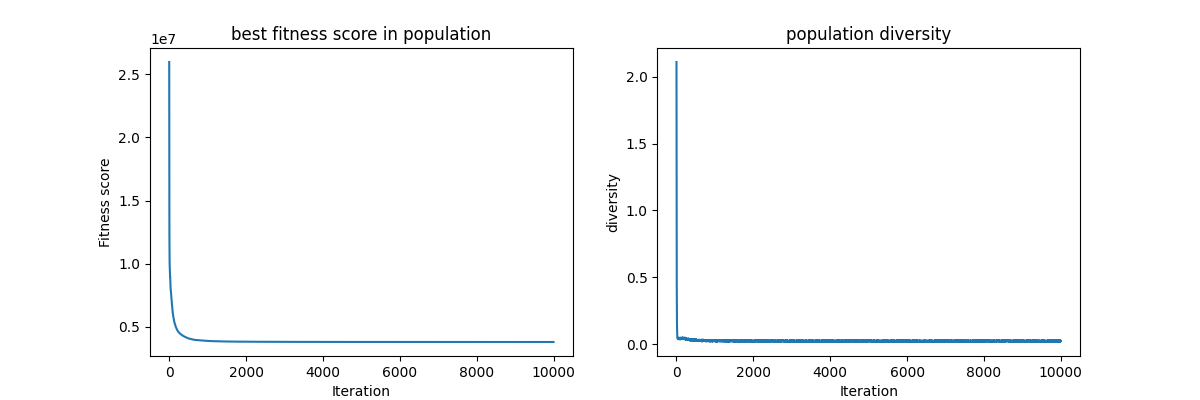

In [28]:
plot_fitness_and_diversity_over_time(experiment1.best_history, experiment1.diversity_history)

### Difference between predicted result and true result

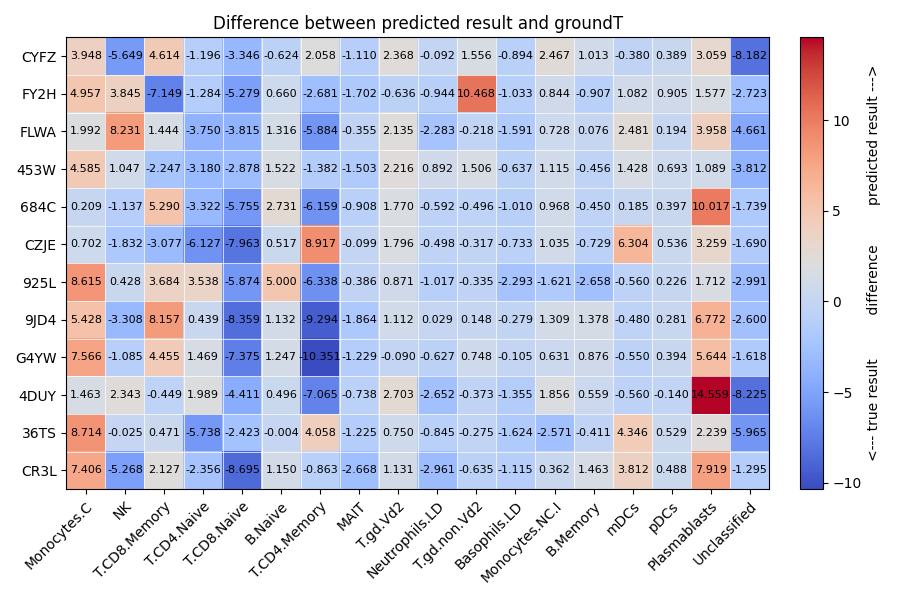

In [29]:
fig, ax = dataframe_heatmap(
    compare_to_true_results(experiment1.result),
    figsize=(9,6),
    cmap="coolwarm",
    annot=True,
    fmt=".3f",
    title="Difference between predicted result and groundT",
    cbar_label="<--- true result          difference         predicted result --->"
)

### solution evaluation report compared to ground truth

In [8]:
metrics1 = evaluate_deconvolution_solution(experiment1.result[:-1], TRUE[:-1], Individual.H, Individual.M, Individual.L,
                                               name="solution 1", 
                                               top_genes=base_parameters["top_n_marker_genes"] if base_parameters["use_marker_genes"] else Individual.H.shape[0], 
                                               eps=base_parameters["min_mean_marker_genes"])


=== Evaluation summary ===


,0
name,solution 1
G,1296
K,17
S,12
fro_candidate,3.79535e+06
fro_true,7.39706e+06
rmse_gene_candidate,15.6219
rmse_gene_true,21.809
mean_abs_resid,5.00586
max_abs_resid,503.646



=== Per-cell metrics (first 12 rows) ===


,cell_index,mae_per_cell,rmse_per_cell,pearson_by_cell,spearman_by_cell
0,0,0.0463209,0.054736,0.822118,0.556352
1,1,0.0284986,0.0371643,0.798001,0.699301
2,2,0.0359685,0.0429995,0.861976,0.755245
3,3,0.0286554,0.0333064,0.736118,0.699301
4,4,0.055143,0.0590273,0.771458,0.755245
5,5,0.0136649,0.0187088,0.959213,0.909091
6,6,0.0542092,0.0623315,-0.0127703,0.041958
7,7,0.0114891,0.0134304,0.882838,0.867133
8,8,0.0146482,0.0165809,0.891743,0.713287
9,9,0.0111926,0.0145616,0.828765,0.706294



=== Per-sample metrics ===


,sample_index,mae_per_sample,rmse_per_sample,js_per_sample
0,0,0.0204488,0.025767,0.0306039
1,1,0.0270301,0.0382292,0.0496659
2,2,0.0237951,0.03196,0.0305784
3,3,0.0166918,0.0196414,0.0356686
4,4,0.0243496,0.0364692,0.0328781
5,5,0.0261411,0.0383788,0.0360805
6,6,0.0265623,0.0360116,0.0236406
7,7,0.0292764,0.0433362,0.0247329
8,8,0.0261406,0.040545,0.0218831
9,9,0.0257122,0.0429998,0.0351888



=== Top residual genes (overall) ===


0         71
1         63
2        174
3         38
4        190
        ... 
1291    1262
1292    1228
1293    1225
1294    1221
1295    1218
Name: top_residual_gene_idx, Length: 1296, dtype: int64

## run 2

In [9]:
parameters2 = base_parameters.copy()
parameters2["rng_seed"] = 465877923
experiment2 = set_parameters(base_parameters, True)
experiment2.run()

running RNA-seq deconvolution:   0%|                                                                          …

stop reason: iteration limit


### Predicted sample$\times$cell-type matrix

In [10]:
as_dataframe('X', experiment2.result)

,Monocytes.C,NK,T.CD8.Memory,T.CD4.Naive,T.CD8.Naive,B.Naive,T.CD4.Memory,MAIT,T.gd.Vd2,Neutrophils.LD,T.gd.non.Vd2,Basophils.LD,Monocytes.NC.I,B.Memory,mDCs,pDCs,Plasmablasts,Unclassified
CYFZ,15.083223,8.364328,29.042409,4.159120e+00,8.055580e-08,5.057371,14.086213,2.169689e-07,3.273167,1.095770,3.315925e+00,0.463533,8.137465,3.525059,4.194650e-07,6.754172e-01,3.246728,4.742713e-01
FY2H,31.761942,6.425392,4.730153,5.883414e+00,5.992509e-08,6.678552,9.600628,4.278665e-01,0.000001,1.258591,2.138322e+01,0.174483,6.724511,0.000004,1.996469e+00,1.269649e+00,1.685122,1.180573e-06
FLWA,21.591530,27.726331,5.943145,2.448774e+00,3.955364e-07,6.781568,11.630826,3.391578e+00,5.531452,1.319986,1.042043e-02,1.023865,1.968597,2.817668,3.092514e+00,6.188950e-01,4.102851,1.616268e-07
453W,23.969063,7.782415,21.094364,7.712995e+00,2.005092e+00,4.105925,13.005993,6.190398e-01,3.271877,2.083707,2.163430e+00,0.307878,3.385907,2.097551,1.825708e+00,1.283449e+00,1.123127,2.162477e+00
684C,19.792555,7.317018,12.153154,5.722653e+00,2.879592e+00,9.450448,14.632055,2.473881e+00,1.869600,1.253689,5.041536e-01,0.846638,3.572113,2.099304,8.010283e-01,1.005892e+00,10.740804,2.885420e+00
CZJE,20.355595,13.916834,1.621263,3.656970e-06,2.037631e+00,7.291455,21.961448,5.112965e+00,4.137067,1.635974,1.726421e-07,0.709276,4.227227,5.204305,7.321853e+00,1.048358e+00,3.418742,1.736457e-06
925L,25.687421,10.174355,16.345497,5.757186e+00,2.207908e-07,17.573650,11.030816,6.110846e-01,3.229974,1.362338,6.285092e-01,1.458852,1.007685,0.324788,5.108801e-07,3.424374e-01,1.789449,2.675959e+00
9JD4,20.086646,4.242439,20.903045,1.215488e+01,2.480752e+00,5.607679,8.937094,1.525159e+00,2.845458,0.628886,2.413052e+00,1.700289,3.689180,4.983270,1.923572e-07,7.800435e-01,6.960530,6.159242e-02
G4YW,26.175382,16.433964,9.182079,1.028924e+01,1.339715e+00,4.945240,5.269106,3.080974e+00,2.350127,0.832074,2.905583e+00,0.367662,4.055213,4.200990,2.044328e-07,6.581887e-01,6.117568,1.796898e+00
4DUY,18.772959,10.327876,4.981717,1.387448e+01,2.491794e+00,5.696728,5.171619,1.785986e+00,8.632676,2.751459,1.050620e-07,0.739096,6.852831,2.715019,1.641404e-07,4.090001e-07,15.205758,7.503450e-07


### Best fitness score and diversity over iterations

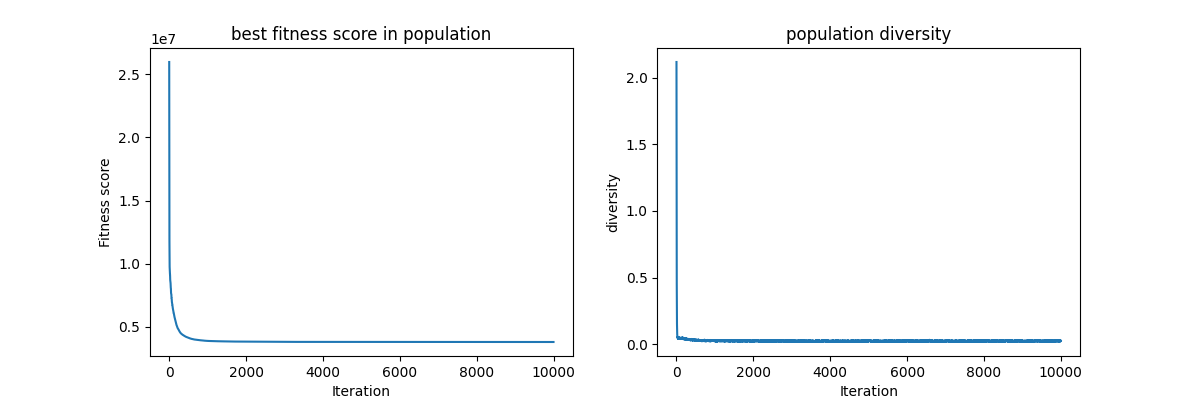

In [11]:
plot_fitness_and_diversity_over_time(experiment2.best_history, experiment2.diversity_history)

### Difference between predicted result and true result

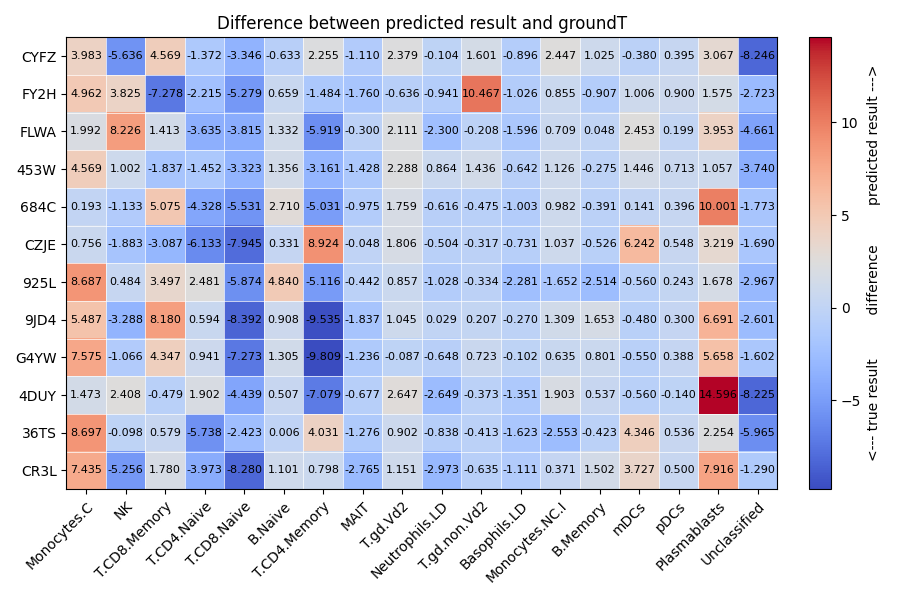

In [30]:
fig, ax = dataframe_heatmap(
    compare_to_true_results(experiment2.result),
    figsize=(9,6),
    cmap="coolwarm",
    annot=True,
    fmt=".3f",
    title="Difference between predicted result and groundT",
    cbar_label="<--- true result          difference         predicted result --->"
)

### solution evaluation report compared to ground truth

In [13]:
metrics2 = evaluate_deconvolution_solution(experiment2.result[:-1], TRUE[:-1], Individual.H, Individual.M, Individual.L,
                                              name="solution 1", 
                                               top_genes=base_parameters["top_n_marker_genes"] if base_parameters["use_marker_genes"] else Individual.H.shape[0], 
                                               eps=base_parameters["min_mean_marker_genes"])


=== Evaluation summary ===


,0
name,solution 1
G,1296
K,17
S,12
fro_candidate,3.79543e+06
fro_true,7.39706e+06
rmse_gene_candidate,15.622
rmse_gene_true,21.809
mean_abs_resid,5.00743
max_abs_resid,503.662



=== Per-cell metrics (first 12 rows) ===


,cell_index,mae_per_cell,rmse_per_cell,pearson_by_cell,spearman_by_cell
0,0,0.0465069,0.0549231,0.820576,0.556352
1,1,0.0285875,0.0371381,0.798326,0.699301
2,2,0.0351015,0.0424536,0.867637,0.776224
3,3,0.0289707,0.0339339,0.750128,0.748252
4,4,0.0549343,0.0584772,0.818724,0.79021
5,5,0.013072,0.0181017,0.959888,0.93007
6,6,0.0526192,0.0603862,-0.0138887,0.034965
7,7,0.011545,0.0136135,0.87576,0.888112
8,8,0.014724,0.0166061,0.890112,0.685315
9,9,0.0112449,0.0146056,0.83116,0.72028



=== Per-sample metrics ===


,sample_index,mae_per_sample,rmse_per_sample,js_per_sample
0,0,0.0207056,0.0259056,0.0306195
1,1,0.0269263,0.0382323,0.0496028
2,2,0.0236518,0.0318847,0.0305504
3,3,0.0164563,0.0196723,0.0356583
4,4,0.0239651,0.0356479,0.0328574
5,5,0.0259044,0.0382922,0.0360677
6,6,0.0250417,0.0341053,0.02355
7,7,0.0295317,0.0436874,0.0247407
8,8,0.0253793,0.0394908,0.0218365
9,9,0.0257174,0.043088,0.0352521



=== Top residual genes (overall) ===


0         71
1         63
2        174
3         38
4        190
        ... 
1291    1262
1292    1228
1293    1221
1294    1218
1295    1225
Name: top_residual_gene_idx, Length: 1296, dtype: int64

## run 3

In [14]:
parameters3 = base_parameters.copy()
parameters3["rng_seed"] = 23454333005
experiment3 = set_parameters(base_parameters, True)
experiment3.run()

running RNA-seq deconvolution:   0%|                                                                          …

stop reason: iteration limit


### Predicted sample$\times$cell-type matrix

In [15]:
as_dataframe('X', experiment3.result)

,Monocytes.C,NK,T.CD8.Memory,T.CD4.Naive,T.CD8.Naive,B.Naive,T.CD4.Memory,MAIT,T.gd.Vd2,Neutrophils.LD,T.gd.non.Vd2,Basophils.LD,Monocytes.NC.I,B.Memory,mDCs,pDCs,Plasmablasts,Unclassified
CYFZ,15.078639,8.367058,29.050526,4.182248e+00,1.598541e-07,5.468519,14.051048,2.700216e-07,3.305943e+00,1.103935,3.270788e+00,0.462885,8.100953,3.142309,7.453855e-07,6.309519e-01,3.319495,4.647000e-01
FY2H,31.773842,6.467681,4.825618,6.059692e+00,8.428415e-08,6.679524,9.358061,4.260004e-01,1.093522e-07,1.257340,2.129856e+01,0.172731,6.689202,0.000002,2.033922e+00,1.268860e+00,1.688966,2.939341e-07
FLWA,21.578095,27.688284,5.948783,2.425745e+00,2.723782e-07,6.850200,11.701443,3.354707e+00,5.568946e+00,1.336109,1.649838e-06,1.024453,1.967683,2.764771,3.080199e+00,6.033192e-01,4.107258,1.865271e-08
453W,23.943030,7.799444,21.141744,7.790491e+00,1.947300e+00,4.151056,13.024081,6.060632e-01,3.285223e+00,2.098846,2.123201e+00,0.309335,3.386874,2.042133,1.854376e+00,1.280009e+00,1.132351,2.084443e+00
684C,19.780299,7.317949,12.312625,6.386242e+00,2.761506e+00,9.471127,13.816020,2.508185e+00,1.876030e+00,1.276236,4.927254e-01,0.845397,3.568687,2.024306,8.490934e-01,1.006384e+00,10.775242,2.931945e+00
CZJE,20.307604,13.890034,1.653384,7.206608e-06,2.062134e+00,7.337551,22.006769,5.057983e+00,4.170954e+00,1.642772,7.326692e-07,0.707325,4.216752,5.151884,7.325972e+00,1.050920e+00,3.417954,3.193340e-07
925L,25.644929,10.118426,16.476642,5.795285e+00,3.274417e-08,17.575593,10.959902,5.849612e-01,3.300967e+00,1.376472,5.580219e-01,1.459980,1.023959,0.328594,5.691495e-07,3.414362e-01,1.796655,2.658175e+00
9JD4,20.062529,4.194437,20.987082,1.231871e+01,2.389979e+00,5.597578,8.868789,1.490849e+00,2.929569e+00,0.613037,2.363614e+00,1.692644,3.675769,4.993556,3.611641e-07,7.843706e-01,6.962497,7.499210e-02
G4YW,26.202382,16.405545,9.163613,1.030554e+01,1.400162e+00,4.985097,5.272997,3.026527e+00,2.318261e+00,0.838329,2.977334e+00,0.371108,4.032658,4.138950,1.691003e-07,6.543709e-01,6.120276,1.786845e+00
4DUY,18.737435,10.273175,5.019843,1.365212e+01,2.610187e+00,5.886705,5.270860,1.733404e+00,8.694616e+00,2.760722,5.090174e-07,0.737232,6.858204,2.545403,6.977966e-08,2.785440e-08,15.220094,1.674304e-07


### Best fitness score and diversity over iterations

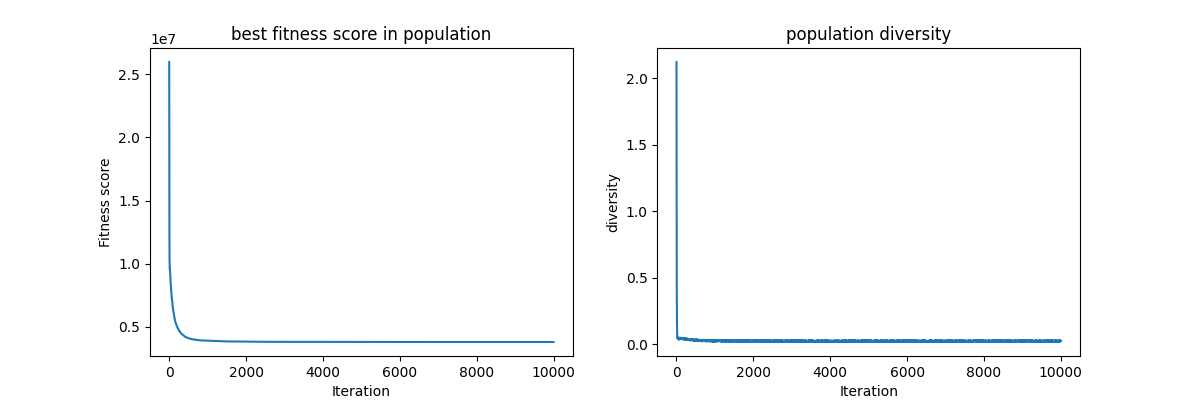

In [16]:
plot_fitness_and_diversity_over_time(experiment3.best_history, experiment3.diversity_history)

### Difference between predicted result and true result

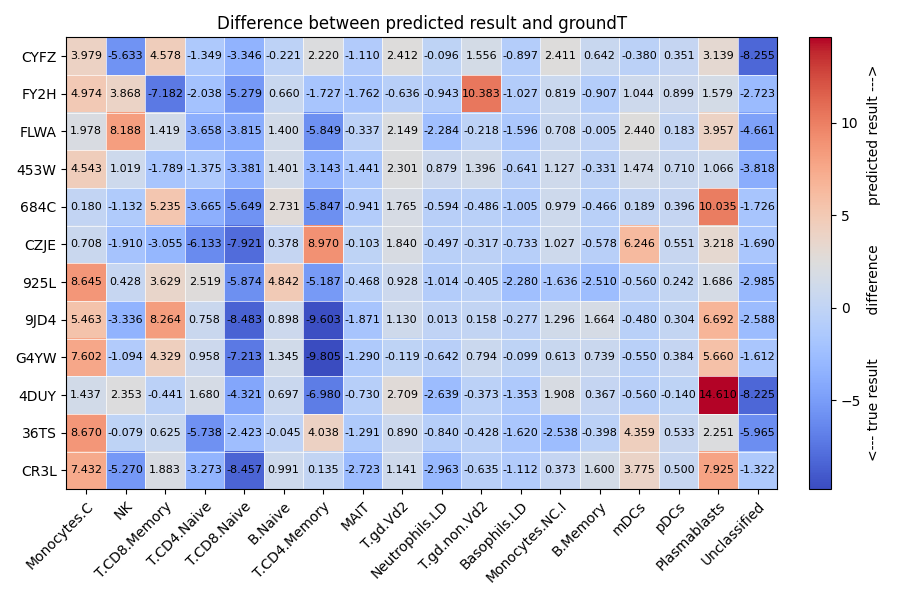

In [31]:
fig, ax = dataframe_heatmap(
    compare_to_true_results(experiment3.result),
    figsize=(9,6),
    cmap="coolwarm",
    annot=True,
    fmt=".3f",
    title="Difference between predicted result and groundT",
    cbar_label="<--- true result          difference         predicted result --->"
)

### solution evaluation report compared to ground truth

In [18]:
metrics3 = evaluate_deconvolution_solution(experiment3.result[:-1], TRUE[:-1], Individual.H, Individual.M, Individual.L,
                                              name="solution 1", 
                                               top_genes=base_parameters["top_n_marker_genes"] if base_parameters["use_marker_genes"] else Individual.H.shape[0], 
                                               eps=base_parameters["min_mean_marker_genes"])


=== Evaluation summary ===


,0
name,solution 1
G,1296
K,17
S,12
fro_candidate,3.7953e+06
fro_true,7.39706e+06
rmse_gene_candidate,15.6218
rmse_gene_true,21.809
mean_abs_resid,5.00722
max_abs_resid,503.685



=== Per-cell metrics (first 12 rows) ===


,cell_index,mae_per_cell,rmse_per_cell,pearson_by_cell,spearman_by_cell
0,0,0.0463428,0.0548104,0.820229,0.556352
1,1,0.0285928,0.0371409,0.797548,0.699301
2,2,0.0353561,0.042702,0.867282,0.776224
3,3,0.0276193,0.0324791,0.771113,0.825175
4,4,0.0551351,0.0587553,0.814052,0.699301
5,5,0.0130069,0.0181509,0.962325,0.902098
6,6,0.05292,0.0610294,-0.0397011,-0.034965
7,7,0.0117233,0.0136699,0.880842,0.888112
8,8,0.0150153,0.0168861,0.888836,0.713287
9,9,0.0111692,0.0145423,0.831238,0.706294



=== Per-sample metrics ===


,sample_index,mae_per_sample,rmse_per_sample,js_per_sample
0,0,0.0201882,0.0257978,0.0305948
1,1,0.0268977,0.0380294,0.0495969
2,2,0.023638,0.0317867,0.0305336
3,3,0.0164807,0.0196645,0.0356652
4,4,0.0242911,0.0362492,0.0328651
5,5,0.02599,0.0383308,0.0360544
6,6,0.0252077,0.0342092,0.0235464
7,7,0.0298168,0.0440094,0.0247453
8,8,0.0254331,0.0394642,0.0218358
9,9,0.0254697,0.0428998,0.0352277



=== Top residual genes (overall) ===


0         71
1         63
2        174
3         38
4        190
        ... 
1291    1262
1292    1228
1293    1218
1294    1225
1295    1221
Name: top_residual_gene_idx, Length: 1296, dtype: int64

## comparison of results

### Variance between results

#### per-cell Variance

In [19]:
as_dataframe('X', np.var([experiment1.result, experiment2.result, experiment3.result], axis=0))

,Monocytes.C,NK,T.CD8.Memory,T.CD4.Naive,T.CD8.Naive,B.Naive,T.CD4.Memory,MAIT,T.gd.Vd2,Neutrophils.LD,T.gd.non.Vd2,Basophils.LD,Monocytes.NC.I,B.Memory,mDCs,pDCs,Plasmablasts,Unclassified
CYFZ,2.454937e-06,4.712816e-07,0.000004,6.108883e-05,1.502821e-17,3.678200e-04,0.000073,3.169097e-17,3.512361e-06,2.615244e-07,4.481192e-06,1.403311e-08,5.339352e-06,3.154527e-04,2.507013e-15,3.873488e-06,1.312049e-05,1.059772e-05
FY2H,4.896653e-07,2.983159e-06,0.000030,1.627245e-03,3.342069e-18,3.014611e-09,0.002669,7.875781e-06,3.262601e-15,7.734917e-09,1.608772e-05,9.412418e-08,2.176805e-06,7.205364e-14,9.385927e-06,7.384236e-08,2.524010e-08,1.611524e-15
FLWA,4.171730e-07,3.704492e-06,0.000002,2.443975e-05,3.122282e-17,1.334258e-05,0.000008,5.236562e-06,2.400173e-06,6.255147e-07,2.409077e-07,5.268377e-08,8.595914e-07,1.130673e-05,2.914443e-06,4.277027e-07,5.500830e-08,3.883388e-17
453W,3.024909e-06,3.438492e-06,0.000422,6.943656e-03,5.047168e-04,4.898620e-05,0.006961,1.063638e-05,1.407114e-05,1.333172e-06,2.073770e-05,4.248387e-08,3.117070e-07,5.686258e-05,3.615847e-06,7.624154e-07,1.810527e-06,1.263400e-05
684C,1.357946e-06,4.778231e-08,0.000083,1.746201e-03,8.312009e-05,9.650401e-07,0.002262,7.600619e-06,2.303695e-07,1.207351e-06,7.362595e-07,7.424286e-08,3.666945e-07,1.041763e-05,4.711349e-06,2.000468e-09,1.981581e-06,3.828122e-06
CZJE,5.732957e-06,1.037398e-05,0.000002,8.321725e-08,2.922662e-06,6.211750e-05,0.000005,6.259342e-06,3.573560e-06,8.895109e-08,6.870343e-16,1.052529e-08,2.024623e-07,7.441337e-05,7.989789e-06,4.452811e-07,3.682943e-06,3.966793e-15
925L,8.859133e-06,7.014905e-06,0.000061,2.393677e-03,9.845646e-17,5.638180e-05,0.003138,1.160481e-05,9.449028e-06,3.651158e-07,1.095689e-05,3.256438e-07,1.613407e-06,4.729305e-05,1.863594e-16,6.134582e-07,2.082482e-06,1.026270e-06
9JD4,5.701810e-06,3.861501e-06,0.000021,1.692012e-04,2.764275e-05,1.165765e-04,0.000175,2.186899e-06,1.312936e-05,5.731611e-07,6.627049e-06,1.741995e-07,3.868143e-07,1.748374e-04,4.780910e-17,1.062702e-06,1.432291e-05,3.635487e-07
G4YW,2.418925e-06,1.388809e-06,0.000031,5.994891e-04,4.456360e-05,1.632283e-05,0.000658,7.620871e-06,2.079930e-06,7.728790e-07,8.840286e-06,6.486161e-08,9.608360e-07,3.133521e-05,7.069310e-17,1.582743e-07,4.757019e-07,4.298279e-07
4DUY,2.253784e-06,8.174688e-06,0.000003,1.692089e-04,2.554117e-05,8.518241e-05,0.000019,7.281947e-06,7.854579e-06,2.892489e-07,3.497098e-16,2.169672e-08,5.493124e-06,7.327318e-05,2.894062e-16,2.781812e-16,4.622722e-06,5.863241e-16


#### fitness score Variance

In [20]:
np.var([experiment1.result_fitness_score, experiment2.result_fitness_score, experiment3.result_fitness_score])

np.float64(2691.134059849066)

### Mean of results

#### per-cell mean

In [21]:
per_cell_mean = as_dataframe('X', np.mean([experiment1.result, experiment2.result, experiment3.result], axis=0))
per_cell_mean

,Monocytes.C,NK,T.CD8.Memory,T.CD4.Naive,T.CD8.Naive,B.Naive,T.CD4.Memory,MAIT,T.gd.Vd2,Neutrophils.LD,T.gd.non.Vd2,Basophils.LD,Monocytes.NC.I,B.Memory,mDCs,pDCs,Plasmablasts,Unclassified
CYFZ,15.069931,8.360904,29.060066,4.225546e+00,1.051254e-07,5.197340,14.008889,2.067529e-07,3.280276e+00,1.102595,3.285989e+00,0.464025,8.131694,3.393388,9.237442e-07,6.585614e-01,3.268457,4.923385e-01
FY2H,31.764331,6.446173,4.805073,6.252218e+00,6.125767e-08,6.679306,9.120809,4.467703e-01,6.067334e-07,1.257459,2.135528e+01,0.171498,6.709080,0.000005,2.033968e+00,1.271162e+00,1.686867,6.145121e-07
FLWA,21.587225,27.715344,5.955380,2.402941e+00,3.167194e-07,6.799313,11.666217,3.360955e+00,5.551889e+00,1.331148,3.479142e-03,1.025773,1.974691,2.809445,3.097893e+00,6.121879e-01,4.106119,1.055744e-07
453W,23.965781,7.803085,20.973468,7.162946e+00,2.134176e+00,4.176235,13.604984,5.897966e-01,3.252306e+00,2.098173,2.173349e+00,0.310002,3.382453,2.018978,1.829444e+00,1.275636e+00,1.136873,2.112313e+00
684C,19.793869,7.315961,12.277976,6.279424e+00,2.765831e+00,9.464340,13.984048,2.507825e+00,1.875657e+00,1.269206,4.933475e-01,0.844125,3.566234,2.054584,8.316218e-01,1.006421e+00,10.757527,2.912003e+00
CZJE,20.321867,13.924855,1.635316,2.045251e-03,2.040080e+00,7.368622,21.973921,5.077661e+00,4.144901e+00,1.640145,3.620143e-07,0.707843,4.222979,5.119004,7.343864e+00,1.044979e+00,3.431916,8.518655e-07
925L,25.649072,10.136899,16.451388,6.122014e+00,1.712200e-07,17.627714,10.599812,6.209002e-01,3.258229e+00,1.370673,6.048330e-01,1.455394,1.023477,0.278076,4.449620e-07,3.364060e-01,1.803042,2.662071e+00
9JD4,20.059205,4.219468,20.923348,1.215791e+01,2.461738e+00,5.678919,8.994474,1.504650e+00,2.895693e+00,0.623741,2.377034e+00,1.694507,3.684560,4.894962,2.807365e-07,7.750255e-01,6.988268,6.649927e-02
G4YW,26.181123,16.418292,9.211735,1.047046e+01,1.326079e+00,4.939020,5.089670,3.065326e+00,2.338596e+00,0.841150,2.937854e+00,0.367884,4.046312,4.205269,1.281950e-07,6.588680e-01,6.114108,1.788256e+00
4DUY,18.757941,10.287901,5.004623,1.382918e+01,2.540552e+00,5.756340,5.209374,1.748132e+00,8.672191e+00,2.753386,3.693867e-07,0.737272,6.839018,2.665794,2.341279e-07,1.759648e-07,15.198297,4.905172e-07


#### Difference between per-cell mean and ground results

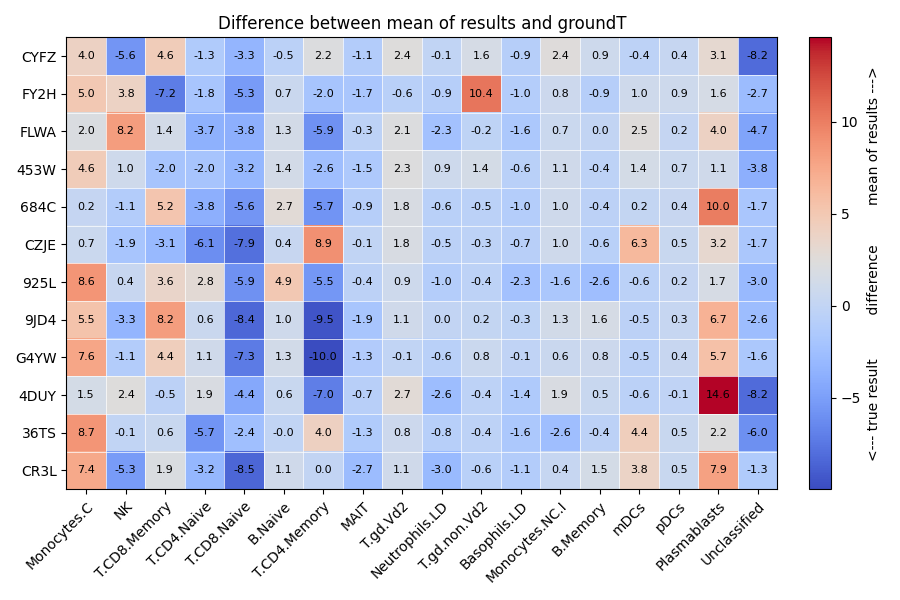

In [33]:
fig, ax = dataframe_heatmap(
    compare_to_true_results(per_cell_mean.transpose() / 100),
    figsize=(9,6),
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    title="Difference between mean of results and groundT",
    cbar_label="<--- true result          difference         mean of results --->"
)